## Introduction
Directly editted in the shared LaTex doc. Please feel free to review and revise! :)

## Reading data

In [1]:
from __future__ import division
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import scipy.stats as stats
import itertools
import random
%matplotlib inline

In [2]:
# Reading data
biyashee_colony_cnts = pd.read_csv('data/Bishayee Colony Counts 10.27.97-3.8.01.csv', skiprows=2)
biyashee_coulter_cnts = pd.read_csv('data/Bishayee Coulter Counts.10.20.97-7.16.01.csv', skiprows=1)
other_colony_cnts = pd.read_csv('data/Other Investigators in Lab.Colony Counts.4.23.92-11.27.02.csv', skiprows=1)
other_coulter_cnts = pd.read_csv('data/Other Investigators in Lab.Coulter Counts.4.15.92-5.21.05.csv', skiprows=1)
outside_coulter_cnts1 = pd.read_csv('data/Outside Lab 1.Coulter Counts.6.7.91-4.9.99.csv')
outside_coulter_cnts2 = pd.read_csv('data/Outside Lab 2.Coulter Counts.6.6.08-7.7.08.csv', skiprows=1)
outside_colony_cnts =  pd.read_csv('data/Outside Lab 3.Colony Counts.2.4.10-5.21.12.csv', skiprows=1)

# standardizing column names for dataframes
biyashee_colony_cnts.columns = ['Isotope', 'Bates', 'Date', 'c1', 'c2', 'c3', 'avg']
biyashee_coulter_cnts.columns = ['Bates', 'Date', 'c1', 'c2', 'c3', 'avg']
other_colony_cnts.columns = ['Bates', 'Date', 'Inv', 'c1', 'c2', 'c3', 'avg']
other_coulter_cnts.columns = ['Bates', 'Date', 'c1', 'c2', 'c3', 'avg', 'Inv']
outside_coulter_cnts1.columns = ['Experiment', 'c1', 'c2', 'c3', 'avg', 'Date']
outside_coulter_cnts2.columns = ['Date', 'c1', 'c2', 'c3', 'avg']
outside_colony_cnts.columns = ['Date', 'c1', 'c2', 'c3', 'avg']

# converting to numerics
biyashee_colony_cnts['c3'] = pd.to_numeric(biyashee_colony_cnts['c3'], errors = 'coerce')
other_colony_cnts['c3'] = pd.to_numeric(other_colony_cnts['c3'], errors = 'coerce')

# filling in experiment and date info
def fill_na(df, column):
    df[column] = df[column].fillna(method='ffill')

fill_na(outside_coulter_cnts1, 'Experiment')
fill_na(outside_coulter_cnts1, 'Date')
fill_na(outside_coulter_cnts2, 'Date')
fill_na(outside_colony_cnts, 'Date')

### Replicate Table 1 by Simulation

In [128]:
def MidProb_Sim(Lambda):
    N = 100000
    a = np.random.poisson(Lambda, 3 * N)
    a = a.reshape(-1,3)
    # Gap greater than or equal to 2
    b = a[np.max(a,axis=1) - np.min(a,axis = 1) >= 2]
    c = np.round(np.mean(b,axis = 1)).astype(int)
    d = (c == b[:,0]) + (c == b[:,1]) + (c == b[:,2])
    return sum(d)/N

### Closed form of Mid prob

##### Use the closed form equation in appendix

In [140]:
# from decimal import *
def Poisson(n, lamb):
    return stats.poisson.pmf(n, lamb)

def entry(j,N,lamb):
    
    P1 = Poisson(range(j,N+1), lamb)
    P2 = Poisson(range(0,N+1-j), lamb)
    P3 = Poisson(range(j-int(j/2), N + 1 - int(j/2)), lamb)
    P4 = (j%2) * Poisson(range(j - int(j/2)-1, N+1-int(j/2)-1), lamb)
    return sum(P1*(P3+P4)*P2)

def GetN(lamb):
    pp = 0
    j = -1
    while pp < 1 - 10**(-9):
        j += 1
        pp += Poisson(j, lamb)
    return j

def MidProb(Lambda):
    P_A = 0
    N = GetN(Lambda)
    for j in range(2, N+1):
        P_A += entry(j,N,Lambda)
    return P_A * 6

In [136]:
%timeit MidProb(100)

10 loops, best of 3: 110 ms per loop


In [127]:
%timeit MidProb_Sim(100)

10 loops, best of 3: 110 ms per loop


In [161]:
# Create table 1 for lambda from 0 to 1999
# Warning: This may take a while!!
prob_table2 = []
i = 0
for Lambda in range(2000):
    i += 1
    if i % 500 == 0:
        print(i)
    prob_table2.append(MidProb(Lambda))

500
1000
1500
2000


#### Print Table 1

In [192]:
prob_table1 = np.asarray(prob_table2)
print('---------------Table 1. Partial MidProb table---------------')
print(prob_table1[1:26].reshape(5,5).T)

---------------Table 1. Partial MidProb table---------------
[[ 0.26702987  0.3718906   0.31731236  0.28050807  0.25429401]
 [ 0.38697539  0.35930389  0.30879198  0.27459372  0.2499085 ]
 [ 0.40296909  0.34750552  0.30091739  0.2690492   0.24575101]
 [ 0.39668663  0.33659691  0.29361874  0.26383824  0.24180244]
 [ 0.38482301  0.32655474  0.28683384  0.25892911  0.23804582]]


In [195]:
# Check if prob never exceeds 0.42
print(max(prob_table1))

0.402969086424


In [193]:
np.savetxt('TableI.csv',prob_table1, fmt='%10.5f')

### Closed form mid prob and simulated mid prob are comparable

In [169]:
print('Mid Prob (lambda = 20) produced by simulation: ', MidProb_Sim(20))
print('Mid Prob (lambda = 20) produced by closed form solution: ', MidProb(20))

Mid Prob (lambda = 20) produced by simulation:  0.25848
Mid Prob (lambda = 20) produced by closed form solution:  0.258929106006


## Triplicate Mean Count
### Replication
#### Hypothesis Testing 1

In [6]:
p = 0.42

n_triplicate_containing_avg = 690
n_samples = 1343
prob = stats.binom.sf(n_triplicate_containing_avg - 1, n_samples, p)
print('RTS data: ', format(prob, '1.3E'))

n_triplicate_containing_avg = 109
n_samples = 572
prob = stats.binom.sf(n_triplicate_containing_avg - 1, n_samples, p)
print('Rest of the lab: ', format(prob, '1.3E'))

RTS data:  2.853E-12
Rest of the lab:  1.000E+00


### Hypothesis Testing II & III
#### Replicating Table 2

#### This Panel Needs R and rpy2 Installed 
Works well on a linux machine

In [40]:
import readline
from rpy2.robjects.packages import importr
from rpy2.robjects import FloatVector
import rpy2.robjects as ro

### Colonies Count

In [217]:
class Testing:
    """
    Input: 
        rawData: dataframe of the count file;
        N_mean: number of samples include its own rounded mean
        prob_table: probability table presented in table 1
    Output:
        Test statistics (all listed in table 2):
            No. expected
            Sd
            Z
            p value
    """
    def __init__(self, rawData, N_mean, prob_table):
        self.rawdata = rawData
        self.N_mean = N_mean
        self.prob_table = prob_table
        
        self.rawData, self.prob = self.GetTestData()
        self.T_Stats = self.TestStats()

    def GetTestData(self):
        raw_dataframe = self.rawdata[['c1','c2','c3']].dropna()
        print('Total Sample Size: ', raw_dataframe.shape[0])
        raw_dataframe['gap'] = raw_dataframe[['c1','c2','c3']].apply(lambda x: np.max(x) - np.min(x), axis = 1)
        raw_dataframe = raw_dataframe[raw_dataframe.gap >= 0]
        print('Complete Sample Size: ', raw_dataframe.shape[0])
        
        raw_dataframe['Mean'] = np.round(raw_dataframe[['c1','c2','c3']].mean(axis = 1)).astype(int)
        
        try:
            raw_dataframe['prob'] = raw_dataframe.Mean.apply(lambda x: self.prob_table[x])
        except:
            raw_dataframe['prob'] = raw_dataframe.Mean.apply(lambda x: MidProb(x))

        prob = raw_dataframe.prob.values

        return raw_dataframe, prob

    def TestStats(self):
        Mu = sum(self.prob)
        Std = np.sqrt(self.prob.dot(1 - self.prob))
        Z = (self.N_mean - 0.5 - Mu)/Std
        
        poibin = importr('poibin')
        pvalue = 1 - poibin.ppoibin(self.N_mean - 1, FloatVector(self.prob.tolist()))[0]
        print('------------------------------')
        print('NO.expected: ', Mu)
        print('Sd: ', Std)
        print('Z: ', Z)
        print('p >= k: ', pvalue)
        print('------------------------------')
        return(Mu, Std, Z, pvalue)

##### RTS

In [218]:
RTS = Testing(biyashee_colony_cnts, 690, prob_table2)

Total Sample Size:  1361
Complete Sample Size:  1361
------------------------------
NO.expected:  220.313684235
Sd:  13.4181445463
Z:  34.9665569743
p >= k:  0.0
------------------------------


##### Others

In [219]:
Others = Testing(other_colony_cnts, 109, prob_table2)

Total Sample Size:  597
Complete Sample Size:  597
------------------------------
NO.expected:  108.234246386
Sd:  9.24816537087
Z:  0.0287358198945
p >= k:  0.48425141788512904
------------------------------


##### Outside Lab

In [216]:
Outside = Testing(outside_colony_cnts, 3, prob_table2)

Total Sample Size:  50
Complete Sample Size:  49
------------------------------
NO.expected:  7.78826919243
Sd:  2.55440142066
Z:  -2.07025769311
p >= k:  0.9892860552887166
------------------------------


### Coulter Count

#### RTS

In [ ]:
RTS_cou = Testing(biyashee_coulter_cnts, 173, prob_table2)

#### Others

In [ ]:
Other_cou = Testing(other_coulter_cnts, 36, prob_table2)

#### Outside Lab I

In [ ]:
Out1_cou = Testing(outside_coulter_cnts1, 0, prob_table2)

#### Outside Lab II

In [ ]:
Out2_cou = Testing(outside_coulter_cnts2, 1, prob_table2)

### Alternative Analysis: Permutation Test
Step 1. Pool all the samples together. We only took the triplicate counts and recomputed the average in the next step.

In [19]:
# pool all samples for triplicate testing:
def triplicate_pool_all_samples(dfs):
    samples = dfs[0][['c1', 'c2', 'c3']]
    for df in dfs[1:]:
        samples = samples.append(df[['c1', 'c2', 'c3']], ignore_index=True)
    return samples

coulter_dfs = [biyashee_coulter_cnts,
               other_coulter_cnts,
               outside_coulter_cnts1,
               outside_coulter_cnts2]

colony_dfs = [biyashee_colony_cnts,
              other_colony_cnts,
              outside_colony_cnts]

coulter_samples = triplicate_pool_all_samples(coulter_dfs)
colony_samples = triplicate_pool_all_samples(colony_dfs)

Step 2. Calculate the average and check if each triplicate contains the mean for the pooled samples.

In [20]:
import warnings
warnings.filterwarnings('ignore')

def contains_mean(df_row):
    '''returns true if any of c1, c2 or c3 equals the triplicate average '''
    return (df_row['mean'] == df_row['c1'] or 
            df_row['mean'] == df_row['c2'] or 
            df_row['mean'] == df_row['c3'])

# clean up data and add a new column to the data frame indicating if the triplicate contains its rounded mean
def triplicate_has_mean(df):
    '''append df with an extra column of booleans indicating if each row of triplicate contains its own mean'''
    # drop NA values and convert c1, c2, c3 to int type
    df = df.dropna()
    df[['c1', 'c2', 'c3']] = df[['c1', 'c2', 'c3']].astype(int)
    
    # calculate mean and append a new column of mean values to df
    df['mean'] = df.mean(axis=1).round(0).astype(int)

    # calculate if each row of triplicate contains its own mean and append a new boolean column to df
    # df['contains_mean'] = df.apply(lambda x: contains_mean(x), axis=1)
    df['contains_mean'] = df.apply(contains_mean, axis=1)
    
    return df

coulter_samples_mean = triplicate_has_mean(coulter_samples)
colony_samples_mean = triplicate_has_mean(colony_samples)

Step 3. Permutation test for triplicate count test.

In [5]:
def tri_perm_test(pooled_samples, n, test_statistic):
    '''permutation test for triplicate mean counts
    pooled_samples should be a series'''
    
    # rv is the hypergeometric variable in question
    rv = stats.hypergeom(pooled_samples.size, pooled_samples.sum(), n)
    
    # Plotting a sample draw (optional)
    (lower, upper) = rv.interval(0.9999)
    x = np.arange(lower, upper)
    plt.plot(x, rv.pmf(x))
    
    # pooled_samples.size is the total number of triplets
    # pooled_samples.sum() is the number of marked triplets
    # n is the number of sampels drawn
    return rv.sf(test_statistic - 1)

Step 4a. Perform the permutation test on coulter samples.

Permutation Test on Coulter Samples
Size of sameple:  1716
Test statistic:  173
Probability that sample permutation >= test statistic:  6.586E-12


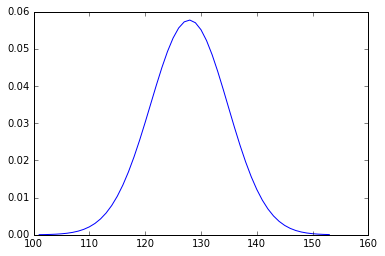

In [6]:
# values of n and test_statistic are obtained from PNAS paper Table 2 (pg 7)
n = 1716
test_statistic = 173

# permutation test on coulter samples (and plot the distribution histogram)
test_result = tri_perm_test(coulter_samples_mean['contains_mean'], n, test_statistic)

# print out key information as output
print "Permutation Test on Coulter Samples"
print "Size of sameple: ", n
print "Test statistic: ", test_statistic
print "Probability that sample permutation >= test statistic: ", format(test_result, '1.3E')

Step 4b. Perform the permutation test on colony samples.

Permutation Test on Colony Samples
Size of sameple:  1343
Test statistic:  690
Probability that sampled permutation >= test statistic:  1.781E-36


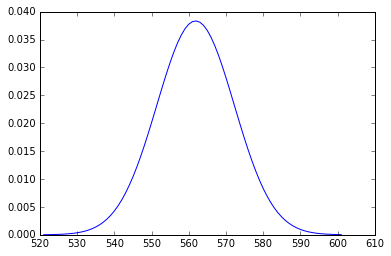

In [7]:
# values of n and test_statistic are obtained from PNAS paper Table 2 (pg 7)
n = 1343
test_statistic = 690

# permutation test on coulter samples (and plot the distribution histogram)
test_result = tri_perm_test(colony_samples_mean['contains_mean'], n, test_statistic)

# print out key information as output
print "Permutation Test on Colony Samples"
print "Size of sameple: ", n
print "Test statistic: ", test_statistic
print "Probability that sampled permutation >= test statistic: ", format(test_result, '1.3E')

## Mid-ratio test

### Expeceted percent of samples with mid-ratio [.40,.60]
For all integer values of $\lambda$ from 1 to 2000, we simmulate 10,000 poisson triplicates and calculate the mid-ratio for each triplicate. Here the mid-ratio is defined as the ratio of the difference between the median and the smallest value of the triplicate to the difference between the largest and smallest value of the triplicate. 
We then calculate the percentage of mid-ratios that fall in the interval [0.4, 0.6]. Our results match with those reported in the paper - the percent of mid ratio test in the interval [0.4, 0.6] never exceeds 0.26.

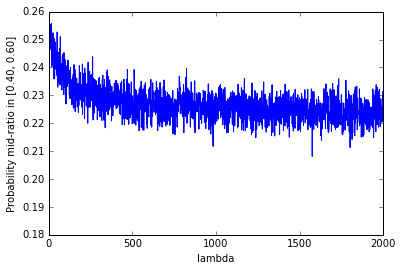

In [8]:
# simulate poison
def mid_ratio(x):
    # x = n x 3 matrix of poisson variables
    return (np.median(x,1)-np.min(x,1))/(np.max(x,1)-np.min(x,1))

def mid_ratio_40_60(x):
    # x = n-vector of mid-ratios
    # returns the percent of samples that have mid-ratio in [.40,.60]
    return np.count_nonzero((x>=.4) & (x<=.6))/float(len(x))

def midratio_poisson_tv(lam, n_sim):
    sim_poisson = stats.poisson.rvs(lam, size = 3*n_sim)
    sim_poisson = sim_poisson.reshape((-1,3))
    mid_ratios = mid_ratio(sim_poisson)
    return mid_ratio_40_60(mid_ratios)


v_midratio_poisson_tv = np.vectorize(midratio_poisson_tv)
# Range of mu we are plotting
x = np.arange(1, 2000)
plt.plot(x, v_midratio_poisson_tv(x, 10000))
plt.xlabel('lambda')
plt.ylabel('Probability mid-ratio in [0.40, 0.60]')
    

Pitt and Hill report that the RTS investigator has a high number of triplicates with a mid-ratio value in the interval [0.4, 0.6], but they do not actually report how unlikely such a result is.

From our investigation, we find that 824 of 1362 colony counts and 523 of 1729 coulter counts produced by the RTS investigator have a mid-ratio value in the interval [0.4, 0.6]. If, as Pitt and Hill suggest, we model the probability of mid-ratio in [0.4, 0.6] as a Bernouli process and conservatively assign the probability of success, p = 0.26, then the probability of observing 824 or more successes in 1362 colony count trials is 1.11e-16. The probability of observing 523 or more successes in 1729 coulter count triplicates is 3.26e-5. Both corroborate the idea that it is very unlikely that a Poisson process produced this many triplicates with midratios in the interval [0.4, 0.6]. 

However, we do take issue with the fact that Pitt and Hill decided to perform this test after observing "what appeared to be an unusual frequency of triples in RTS data containing a value close to their mean. Other investigators  besides RTS may well have trends that make their data look anomylous, and that would also have a low probability of happening by chance.

In [9]:
rts_mid_ratios_colony = mid_ratio(biyashee_colony_cnts[['c1','c2','c3']].values)
rts_mid_ratio_count_colony = mid_ratio_40_60(rts_mid_ratios_colony) * len(rts_mid_ratios_colony)
print '%i of %i RTS colony triplicates have mid-ratios in interval [0.4,0.6]' %(rts_mid_ratio_count_colony,
                                                                                len(rts_mid_ratios_colony))

rts_mid_ratios_coulter = mid_ratio(biyashee_coulter_cnts[['c1','c2','c3']].values)
rts_mid_ratio_count_coulter = mid_ratio_40_60(rts_mid_ratios_coulter) * len(rts_mid_ratios_coulter)
print '%i of %i RTS coulter triplicates have mid-ratios in interval [0.4,0.6]' %(rts_mid_ratio_count_coulter,
                                                                                len(rts_mid_ratios_coulter))

prob_rts_mid_ratio_colony = 1-stats.binom.cdf(rts_mid_ratio_count_colony,len(rts_mid_ratios_colony),.26)
prob_rts_mid_ratio_coulter =  1-stats.binom.cdf(rts_mid_ratio_count_coulter,len(rts_mid_ratios_coulter),.26)

print 'p of seeing at least %i of %i triplicates with mid-ratios in interval [0.4,0.6] = %.4g' %(
    rts_mid_ratio_count_colony,len(rts_mid_ratios_colony),prob_rts_mid_ratio_colony)
print 'p of seeing at least %i of %i triplicates with mid-ratios in interval [0.4,0.6] = %.4g' %(
    rts_mid_ratio_count_coulter,len(rts_mid_ratios_coulter),prob_rts_mid_ratio_coulter)

824 of 1362 RTS colony triplicates have mid-ratios in interval [0.4,0.6]
523 of 1729 RTS coulter triplicates have mid-ratios in interval [0.4,0.6]
p of seeing at least 824 of 1362 triplicates with mid-ratios in interval [0.4,0.6] = 1.11e-16
p of seeing at least 523 of 1729 triplicates with mid-ratios in interval [0.4,0.6] = 3.262e-05


## Terminal digits analysis
### Testing the assumptions
#### Is the terminal digit of a Poisson variable uniform?
For each `mu`, we compute its total variation distance of the terminal digit distribution again the uniform distribution. We generate a vector containing 99.9% its probability mass. We reshape it into an array with 10 columns, allowing us to add the probability mass by terminal digits.

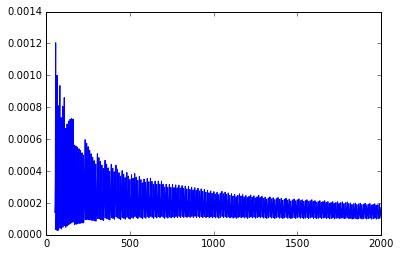

In [10]:
def termd_poisson_tv(mu):
    '''computes the total variation distance of the terminal digit distribution against uniform'''
    # Computes the probability mass, tail probability disregarded
    num_comp = np.ceil(stats.poisson.ppf(0.999, mu) / 10) * 10
    prob = stats.poisson.pmf(np.arange(num_comp), mu)
    # Normalization by 1-norm
    prob = prob / np.linalg.norm(prob, 1)
    # Reshaping prob into 10 columns so each row can be added
    prob = np.reshape(prob, (-1, 10))
    return np.linalg.norm(prob.sum(axis=0) - np.ones(10) / 10, 1)

v_termd_poisson_tv = np.vectorize(termd_poisson_tv)
# Range of mu we are plotting
x = np.arange(50, 2000)
plt.plot(x, v_termd_poisson_tv(x))

As observed above, the total variation distance is moderately close to 0. (The lack of convergence to 0 is due to the a truncated Poisson distribution is used in computation.) This validates the assumption.

#### Is the last two digits of a Poisson variable, conditioned on being three or more digits, the same approximately 10% of the time?

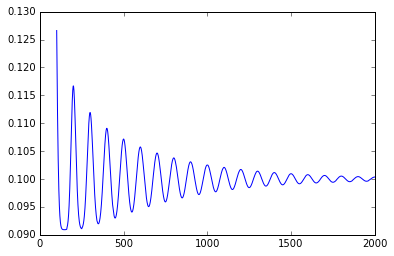

In [11]:
def term2d_poisson_tv(mu):
    '''computes the total variation distance of the terminal digit distribution against uniform'''
    # Computes the probability mass, tail probability disregarded
    num_comp = np.ceil(stats.poisson.ppf(0.999, mu) / 100) * 100
    prob = stats.poisson.pmf(np.arange(100, num_comp), mu)
    # Normalization by 1-norm
    prob = prob / np.linalg.norm(prob, 1)
    # Reshaping prob into 10 columns so each row can be added
    prob = np.reshape(prob, (-1, 100))
    return np.sum(prob[:, 0:100:11])

v_term2d_poisson_tv = np.vectorize(term2d_poisson_tv)
# Range of mu we are plotting
x = np.arange(100, 2000)
plt.plot(x, v_term2d_poisson_tv(x))

Since a lot of the counts by RTS are around 100, the assumption of 10% is not very valid in this regime. This is porticularly troublesome when the true parameter $\lambda$ is smaller than or comparable to 100. It is significantly more likely to observe 100 than 111, upsetting the uniform distribution assumption. Subject to imprecision of model specification, it does not seem that unlikely that RTS has a ~12% matching last two digits.

### Replication

In [17]:
def termd_count(df):
    '''counts the terminal digit in dataframe df. df must have c1, c2, c3'''
    c1_termd = df['c1'].mod(10).value_counts().sort_index()
    c2_termd = df['c2'].mod(10).value_counts().sort_index()
    c3_termd = df['c3'].mod(10).value_counts().sort_index()
    return list(c1_termd + c2_termd + c3_termd)

# corresponds to table 3 in Pitt and Hill
table3 = pd.DataFrame([termd_count(biyashee_colony_cnts),
                       termd_count(biyashee_coulter_cnts),
                       termd_count(other_colony_cnts),
                       termd_count(other_coulter_cnts),
                       termd_count(outside_coulter_cnts1),
                       termd_count(outside_coulter_cnts2),
                       termd_count(outside_colony_cnts)],
                      columns = range(10))
table3['index'] = pd.Series(['biyashee_colony_cnts', 'biyashee_coulter_cnts',
                             'other_colony_cnts', 'other_coulter_cnts',
                             'outside_coulter_cnts1', 'outside_coulter_cnts2',
                             'outside_colony_cnts'],
                            index=table3.index)
table3.set_index('index', inplace=True)
table3.index.name = None
table3['total'] = table3.sum(axis=1)
table3['chi-square'] = 0
for i in range(10):
    table3['chi-square'] += (table3[i] - table3['total'] / 10) ** 2 / (table3['total'] / 10)
table3['p'] = stats.chisqprob(table3['chi-square'], 9)
table3

,0,1,2,3,4,5,6,7,8,9,total,chi-square,p
biyashee_colony_cnts,564,324,463,313,290,478,336,408,383,526,4085,200.725826,2.333780e-38
biyashee_coulter_cnts,475,613,736,416,335,732,363,425,372,718,5185,466.874638,7.062273e-95
other_colony_cnts,191,181,195,179,184,175,178,185,185,181,1834,1.790622,9.943625e-01
other_coulter_cnts,261,311,295,259,318,290,298,283,331,296,2942,15.994562,6.699524e-02
outside_coulter_cnts1,28,34,29,25,27,36,44,33,26,33,315,9.476190,3.945273e-01
outside_coulter_cnts2,34,38,45,35,32,42,31,35,35,33,360,4.944444,8.391240e-01
outside_colony_cnts,21,9,15,16,19,19,9,19,11,12,150,12.133333,2.058966e-01


Although the `total` column in the paper does not add up correctly, fixing it did not change the p-values much.

### Alternative analysis: Permutation test

Step 1. Pool all the samples together.

In [13]:
# pool all samples:
def pool_all_samples(dfs):
    samples = np.array([])
    for df in dfs:
        samples = np.append(samples,df[['c1','c2','c3']].values.flatten())
    return samples

coulter_dfs = [biyashee_coulter_cnts,
               other_coulter_cnts,
               outside_coulter_cnts1,
               outside_coulter_cnts2]

colony_dfs = [biyashee_colony_cnts,
              other_colony_cnts,
              outside_colony_cnts]


coulter_samples = pool_all_samples(coulter_dfs)
colony_samples = pool_all_samples(colony_dfs)

Step 2. Permutation test for how far sample is from uniform

In [14]:
def chi_squared_term_digit(samples):
    chi_squared = 0
    termd = samples%10
    for i in range(10):
        ni = np.count_nonzero(termd == i)
        N = len(samples) # TODO fix to remove non-numbers
        chi_squared += (ni - N / 10.) ** 2 / (N / 10)
    return chi_squared
        

def perm_test(pooled_samples, n, n_perm, test_statistic):
    '''
    pooled_samples = all samples 
    n = number of samples in group of interest
    test_statistic = value of observed test statistic to plot against
    n_iter = number of iterations
    '''
    test_statistics = np.array([])
    for i in range(n_perm):
        # take 1st n samples
        samples = pooled_samples[np.random.permutation(len(pooled_samples))[0:n]]  #array(i[0:n])
        # compute test statistic on these samples
        test_statistics = np.append(test_statistics, chi_squared_term_digit(samples))

    # Plotting a sample draw (optional)
    plt.hist(test_statistics, bins=50)
    plt.show()
    
    return np.count_nonzero(test_statistics>test_statistic)/float(len(test_statistics))

Step 3a. Perform the permutation test on coulter samples.

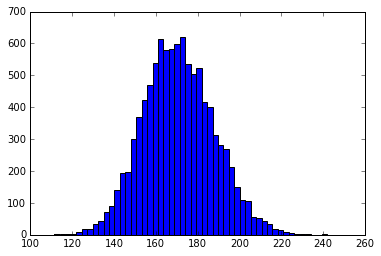

Permutation Test on Coulter Samples
Size of sameple:  5187
Test statistic:  467.326061776
Probability that sample permutation >= test statistic:  0.000E+00


In [15]:
test_samples = pool_all_samples([biyashee_coulter_cnts])
n = len(test_samples)
n_perm = 10000
test_statistic = chi_squared_term_digit(test_samples)
test_result = perm_test(coulter_samples, n, n_perm, test_statistic)

print "Permutation Test on Coulter Samples"
print "Size of sameple: ", n
print "Test statistic: ", test_statistic
print "Probability that sample permutation >= test statistic: ", format(test_result, '1.3E')

Step 3b. Perform the permutation test on colony samples.

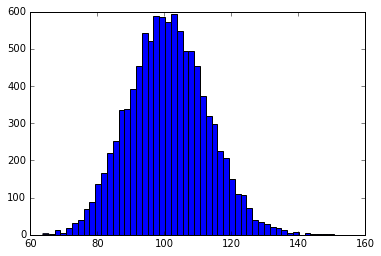

Permutation Test on Coulter Samples
Size of sameple:  4086
Test statistic:  200.972058824
Probability that sample permutation >= test statistic:  0.000E+00


In [16]:
test_samples = pool_all_samples([biyashee_colony_cnts])
n = len(test_samples)
n_perm = 10000
test_statistic = chi_squared_term_digit(test_samples)
test_result = perm_test(colony_samples, n, n_perm, test_statistic)

print "Permutation Test on Coulter Samples"
print "Size of sameple: ", n
print "Test statistic: ", test_statistic
print "Probability that sample permutation >= test statistic: ", format(test_result, '1.3E')